## Music Information Retrieval (MIR)

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import librosa
import musdb

## 1. Prepare Data :

In [6]:
def prepare_dataset(mus, n_fft=1024, hop_length=768, patch_size=128, overlap=0, downsampling_freq=8192):
    """
    Prepare a dataset of spectrograms for training or testing.
    """
    dataset = []
    step = patch_size - overlap

    for track in tqdm(mus.tracks, desc="Processing dataset"):
        # Downsample and compute stereo average
        mix = librosa.resample(np.mean(track.audio.T, axis=0), 
                             orig_sr=track.rate, 
                             target_sr=downsampling_freq)
        vocals = librosa.resample(np.mean(track.targets['vocals'].audio.T, axis=0), 
                                orig_sr=track.rate, 
                                target_sr=downsampling_freq)

        # Compute STFT
        X_complex = librosa.stft(mix, n_fft=n_fft, hop_length=hop_length)
        Y_complex = librosa.stft(vocals, n_fft=n_fft, hop_length=hop_length)

        # Compute magnitude and phase
        X_mag = np.abs(X_complex)
        X_phase = np.angle(X_complex)
        Y_mag = np.abs(Y_complex)
        Y_phase = np.angle(Y_complex)

        # Split into patches
        for i in range(0, X_mag.shape[1] - patch_size + 1, step):
            X_mag_patch = X_mag[:, i:i+patch_size]
            X_phase_patch = X_phase[:, i:i+patch_size]
            Y_mag_patch = Y_mag[:, i:i+patch_size]
            Y_phase_patch = Y_phase[:, i:i+patch_size]
            
            # Add channel dimension
            X_mag_patch = torch.tensor(X_mag_patch, dtype=torch.float32).unsqueeze(0)
            Y_mag_patch = torch.tensor(Y_mag_patch, dtype=torch.float32).unsqueeze(0)
            
            dataset.append((
                (X_mag_patch, torch.tensor(X_phase_patch, dtype=torch.float32)),
                (Y_mag_patch, torch.tensor(Y_phase_patch, dtype=torch.float32))
            ))

    return dataset

class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, spectrogram_list, is_training=True):
        self.spectrogram_list = spectrogram_list
        self.is_training = is_training

    def __len__(self):
        return len(self.spectrogram_list)

    def __getitem__(self, idx):
        (X_mag, X_phase), (Y_mag, Y_phase) = self.spectrogram_list[idx]

        # Crop to 512 frequency bins
        X_mag = X_mag[:, :512, :]
        Y_mag = Y_mag[:, :512, :]
        X_phase = X_phase[:512, :]
        Y_phase = Y_phase[:512, :]

        # Normalize only during training
        if self.is_training:
            X_mag = (X_mag - torch.min(X_mag)) / (torch.max(X_mag) - torch.min(X_mag) + 1e-10)
            Y_mag = (Y_mag - torch.min(Y_mag)) / (torch.max(Y_mag) - torch.min(Y_mag) + 1e-10)

        return X_mag, X_phase, Y_mag, Y_phase

In [ ]:
train_mus = musdb.DB(root="../data/musdb18", subsets="train")
test_mus = musdb.DB(root="../data/musdb18", subsets="test")
print(train_mus)

train_data = prepare_dataset(train_mus)
test_data = prepare_dataset(test_mus)

In [ ]:
torch.save(train_data, "data/processed_data_v2/train_data.pt")
torch.save(test_data, "data/processed_data_v2/test_data.pt") 

In [4]:
train_data = torch.load("../data/processed_data_v2/train_data.pt")
test_data = torch.load("../data/processed_data_v2/test_data.pt")

C:\Users\PSDJ8092\AppData\Local\Temp\1\ipykernel_1696\3527330856.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("../data/processed_data_v2/train

In [15]:
batch_size = 64

train_dataset = SpectrogramDataset(train_data, is_training=True)
val_dataset = SpectrogramDataset(test_data, is_training=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# verification of dimentionality :
batch = next(iter(val_loader))
print(len(batch))
print(batch[0].shape)

4
torch.Size([64, 1, 512, 128])


## 2. UNet Model :

In [9]:
class _UNet(nn.Module):
    def __init__(self):
        super(_UNet, self).__init__()
        
        # Encoder: Convolutional layers
        self.enc1 = self.conv_block(1, 16)
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)
        self.enc5 = self.conv_block(128, 256)
        self.enc6 = self.conv_block(256, 512)

        # Decoder: Upsampling + Conv2d layers
        self.dec6 = self.upconv_block(512, 256)
        self.dec5 = self.upconv_block(256, 128)
        self.dec4 = self.upconv_block(128, 64)
        self.dec3 = self.upconv_block(64, 32)
        self.dec2 = self.upconv_block(32, 16)
        self.dec1 = self.final_upconv(16, 1)  # Upsample to match (512, 128) and output single channel
        
    def conv_block(self, in_channels, out_channels):
        """
        A block consisting of Conv2D, BatchNorm, and LeakyReLU.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def upconv_block(self, in_channels, out_channels):
        """
        A block consisting of Upsample, Conv2D, BatchNorm, and ReLU.
        """
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def final_upconv(self, in_channels, out_channels):
        """
        Final upsampling layer to match the input dimensions.
        """
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),  # Single channel
            nn.Sigmoid()  # For output mask
        )
        
    def forward(self, x):

        # Encoding path
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        
        # Decoding path with skip connections
        d6 = self.dec6(e6)
        d5 = self.dec5(d6 + e5)
        d4 = self.dec4(d5 + e4)
        d3 = self.dec3(d4 + e3)
        d2 = self.dec2(d3 + e2)
        
        # Final layer to match input dimensions
        out = self.dec1(d2 + e1)
        
        return out

In [10]:
model = _UNet()
model.eval()
model

_UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(

### Pass data throw the Model 
Test the model with dummy data :

In [11]:
# Create a dummy input tensor with shape (batch_size, channels, freq_bins, time_frames)
dummy_input = torch.randn(64, 1, 512, 128)  # Batch size = 64, Channels = 1, Freq bins = 512, Time frames = 128
output = model(dummy_input)

print("Input shape:", dummy_input.shape)  # Should be (1, 1, 512, 128)
print("Output shape:", output.shape)      # Should be (1, 1, 512, 128)

Input shape: torch.Size([64, 1, 512, 128])
Output shape: torch.Size([64, 1, 512, 128])


Test the model with real data :

In [13]:
batch = next(iter(train_loader))  # Get the first batch
X_amp, Y_amp = batch[0], batch[2]
print("Input X_amp shape:", X_amp.shape)  # Example: (4, 1, 512, 128)

with torch.no_grad():  # No gradients needed for inference
    predicted_mask = model(X_amp)

print("Predicted mask shape:", predicted_mask.shape)  # Should match input: (4, 1, 512, 128)

Input X_amp shape: torch.Size([64, 1, 512, 128])
Predicted mask shape: torch.Size([64, 1, 512, 128])


___

## 3. Train the Model :
with classic Pytorch :

In [38]:
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

num_epochs = 50
learning_rate = 1e-3

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = _UNet().to(device)

# Define L1 loss with masking applied
def l1_masked_loss(predicted_mask, input_spectrogram, target_spectrogram):
    estimated_spectrogram = predicted_mask * input_spectrogram
    return F.l1_loss(estimated_spectrogram, target_spectrogram)

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Function to evaluate the model
def evaluate_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X, _, Yv, _ in dataloader:
            X = X.to(device)
            Yv = Yv.to(device)

            # Forward pass
            predicted_mask = model(X)

            # Compute loss
            loss = loss_fn(predicted_mask, X, Yv)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    # avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss

# Logging for loss
train_losses = []
val_losses = []

# Evaluate the untrained model
initial_loss = evaluate_model(model, val_loader, l1_masked_loss)
print(f"Initial Model - Loss: {initial_loss:.6f}")

# Training Loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # Accumulate epoch loss

    for X, _, Yv, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X = X.to(device)
        Yv = Yv.to(device)

        # Forward pass
        predicted_mask = model(X)
        predictions = X * predicted_mask  # Apply mask to input

        # Compute loss
        loss = l1_masked_loss(predicted_mask, X, Yv)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Adjust learning rate
    scheduler.step()

    # Compute epoch-level average loss and accuracy
    avg_loss = epoch_loss / len(train_loader)

    train_losses.append(avg_loss)

    # Evaluate on validation set
    val_loss = evaluate_model(model, val_loader, l1_masked_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.6f} \t"
          f"Validation Loss: {val_loss:.6f}")

Initial Model - Loss: 0.011044


Epoch 1/50: 100%|██████████| 77/77 [02:14<00:00,  1.74s/it]


Epoch 1/50, Training Loss: 0.009259Validation Loss: 0.008407


Epoch 2/50: 100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Epoch 2/50, Training Loss: 0.008481Validation Loss: 0.007702


Epoch 3/50: 100%|██████████| 77/77 [02:20<00:00,  1.82s/it]


Epoch 3/50, Training Loss: 0.008262Validation Loss: 0.007638


Epoch 4/50: 100%|██████████| 77/77 [02:42<00:00,  2.12s/it]


Epoch 4/50, Training Loss: 0.008029Validation Loss: 0.007519


Epoch 5/50: 100%|██████████| 77/77 [03:03<00:00,  2.39s/it]


Epoch 5/50, Training Loss: 0.007903Validation Loss: 0.007654


Epoch 6/50: 100%|██████████| 77/77 [02:40<00:00,  2.09s/it]


Epoch 6/50, Training Loss: 0.007715Validation Loss: 0.007267


Epoch 7/50: 100%|██████████| 77/77 [02:34<00:00,  2.01s/it]


Epoch 7/50, Training Loss: 0.007612Validation Loss: 0.007277


Epoch 8/50: 100%|██████████| 77/77 [02:18<00:00,  1.80s/it]


Epoch 8/50, Training Loss: 0.007526Validation Loss: 0.007147


Epoch 9/50: 100%|██████████| 77/77 [02:15<00:00,  1.76s/it]


Epoch 9/50, Training Loss: 0.007440Validation Loss: 0.007096


Epoch 10/50: 100%|██████████| 77/77 [02:37<00:00,  2.05s/it]


Epoch 10/50, Training Loss: 0.007370Validation Loss: 0.007136


Epoch 11/50: 100%|██████████| 77/77 [02:59<00:00,  2.33s/it]


Epoch 11/50, Training Loss: 0.007230Validation Loss: 0.007174


Epoch 12/50: 100%|██████████| 77/77 [02:45<00:00,  2.15s/it]


Epoch 12/50, Training Loss: 0.007174Validation Loss: 0.007138


Epoch 13/50: 100%|██████████| 77/77 [02:47<00:00,  2.18s/it]


Epoch 13/50, Training Loss: 0.007120Validation Loss: 0.007347


Epoch 14/50: 100%|██████████| 77/77 [02:45<00:00,  2.14s/it]


Epoch 14/50, Training Loss: 0.007081Validation Loss: 0.007004


Epoch 15/50: 100%|██████████| 77/77 [02:31<00:00,  1.96s/it]


Epoch 15/50, Training Loss: 0.007039Validation Loss: 0.007268


Epoch 16/50: 100%|██████████| 77/77 [02:31<00:00,  1.97s/it]


Epoch 16/50, Training Loss: 0.006970Validation Loss: 0.007054


Epoch 17/50: 100%|██████████| 77/77 [02:26<00:00,  1.91s/it]


Epoch 17/50, Training Loss: 0.006932Validation Loss: 0.007074


Epoch 18/50: 100%|██████████| 77/77 [02:20<00:00,  1.82s/it]


Epoch 18/50, Training Loss: 0.006915Validation Loss: 0.006985


Epoch 19/50: 100%|██████████| 77/77 [02:08<00:00,  1.67s/it]


Epoch 19/50, Training Loss: 0.006880Validation Loss: 0.007002


Epoch 20/50: 100%|██████████| 77/77 [02:28<00:00,  1.93s/it]


Epoch 20/50, Training Loss: 0.006875Validation Loss: 0.007032


Epoch 21/50: 100%|██████████| 77/77 [02:24<00:00,  1.88s/it]


Epoch 21/50, Training Loss: 0.006839Validation Loss: 0.006983


Epoch 22/50: 100%|██████████| 77/77 [02:20<00:00,  1.83s/it]


Epoch 22/50, Training Loss: 0.006829Validation Loss: 0.007003


Epoch 23/50: 100%|██████████| 77/77 [02:20<00:00,  1.82s/it]


Epoch 23/50, Training Loss: 0.006821Validation Loss: 0.007083


Epoch 24/50: 100%|██████████| 77/77 [02:20<00:00,  1.83s/it]


Epoch 24/50, Training Loss: 0.006819Validation Loss: 0.007053


Epoch 25/50: 100%|██████████| 77/77 [02:21<00:00,  1.84s/it]


Epoch 25/50, Training Loss: 0.006797Validation Loss: 0.007051


Epoch 26/50: 100%|██████████| 77/77 [02:20<00:00,  1.82s/it]


Epoch 26/50, Training Loss: 0.006779Validation Loss: 0.007048


Epoch 27/50: 100%|██████████| 77/77 [02:26<00:00,  1.90s/it]


Epoch 27/50, Training Loss: 0.006779Validation Loss: 0.006998


Epoch 28/50: 100%|██████████| 77/77 [02:34<00:00,  2.01s/it]


Epoch 28/50, Training Loss: 0.006767Validation Loss: 0.006966


Epoch 29/50: 100%|██████████| 77/77 [02:29<00:00,  1.94s/it]


Epoch 29/50, Training Loss: 0.006766Validation Loss: 0.007087


Epoch 30/50: 100%|██████████| 77/77 [02:30<00:00,  1.95s/it]


Epoch 30/50, Training Loss: 0.006772Validation Loss: 0.007000


Epoch 31/50: 100%|██████████| 77/77 [02:23<00:00,  1.87s/it]


Epoch 31/50, Training Loss: 0.006758Validation Loss: 0.007002


Epoch 32/50: 100%|██████████| 77/77 [02:24<00:00,  1.87s/it]


Epoch 32/50, Training Loss: 0.006751Validation Loss: 0.007016


Epoch 33/50: 100%|██████████| 77/77 [02:24<00:00,  1.87s/it]


Epoch 33/50, Training Loss: 0.006747Validation Loss: 0.007005


Epoch 34/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 34/50, Training Loss: 0.006742Validation Loss: 0.007008


Epoch 35/50: 100%|██████████| 77/77 [02:22<00:00,  1.86s/it]


Epoch 35/50, Training Loss: 0.006738Validation Loss: 0.007016


Epoch 36/50: 100%|██████████| 77/77 [02:22<00:00,  1.86s/it]


Epoch 36/50, Training Loss: 0.006743Validation Loss: 0.007045


Epoch 37/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 37/50, Training Loss: 0.006741Validation Loss: 0.007039


Epoch 38/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 38/50, Training Loss: 0.006742Validation Loss: 0.007025


Epoch 39/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 39/50, Training Loss: 0.006743Validation Loss: 0.007017


Epoch 40/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 40/50, Training Loss: 0.006737Validation Loss: 0.007007


Epoch 41/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 41/50, Training Loss: 0.006732Validation Loss: 0.007006


Epoch 42/50: 100%|██████████| 77/77 [02:24<00:00,  1.87s/it]


Epoch 42/50, Training Loss: 0.006726Validation Loss: 0.007033


Epoch 43/50: 100%|██████████| 77/77 [02:23<00:00,  1.86s/it]


Epoch 43/50, Training Loss: 0.006735Validation Loss: 0.007045


Epoch 44/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 44/50, Training Loss: 0.006724Validation Loss: 0.007010


Epoch 45/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 45/50, Training Loss: 0.006726Validation Loss: 0.007026


Epoch 46/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 46/50, Training Loss: 0.006730Validation Loss: 0.007052


Epoch 47/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 47/50, Training Loss: 0.006731Validation Loss: 0.007016


Epoch 48/50: 100%|██████████| 77/77 [02:23<00:00,  1.86s/it]


Epoch 48/50, Training Loss: 0.006728Validation Loss: 0.007043


Epoch 49/50: 100%|██████████| 77/77 [02:22<00:00,  1.85s/it]


Epoch 49/50, Training Loss: 0.006727Validation Loss: 0.007041


Epoch 50/50: 100%|██████████| 77/77 [02:21<00:00,  1.84s/it]


Epoch 50/50, Training Loss: 0.006729Validation Loss: 0.006986


Save the model :

In [41]:
torch.save(model.state_dict(), "model.pth")

print("Model saved successfully!")

Model saved successfully!


Load the model :

In [ ]:

# Load the model state dictionary
loaded_model = _UNet()  # Create a new model instance
loaded_model.load_state_dict(torch.load("model_50_epochs.pth"))

C:\Users\PSDJ8092\AppData\Local\Temp\1\ipykernel_1696\2084071258.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("model_50_epochs

<All keys matched successfully>

Plot Training and Validation loss :

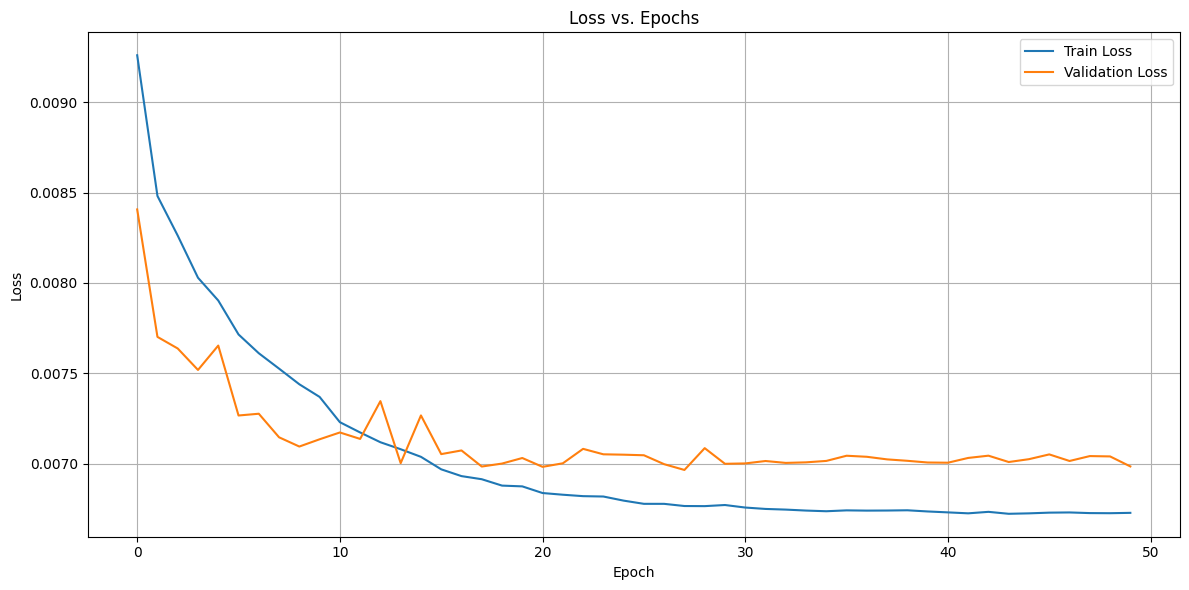

Training complete!


In [40]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

print("Training complete!")

After 25 epochs, we observe that the model converges. Therefore, we will retrain the model for only 25 epochs

In [43]:
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

num_epochs = 25
learning_rate = 1e-3

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = _UNet().to(device)

# Define L1 loss with masking applied
def l1_masked_loss(predicted_mask, input_spectrogram, target_spectrogram):
    estimated_spectrogram = predicted_mask * input_spectrogram
    return F.l1_loss(estimated_spectrogram, target_spectrogram)

# Optimizer and Scheduler
optimizer = optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Function to evaluate the model
def evaluate_model(model2, dataloader, loss_fn):
    model2.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X, _, Yv, _ in dataloader:
            X = X.to(device)
            Yv = Yv.to(device)

            # Forward pass
            predicted_mask = model2(X)

            # Compute loss
            loss = loss_fn(predicted_mask, X, Yv)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    # avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss

# Logging for loss
train_losses = []
val_losses = []

# Evaluate the untrained model
initial_loss = evaluate_model(model2, val_loader, l1_masked_loss)
print(f"Initial Model - Loss: {initial_loss:.6f}")

# Training Loop
for epoch in range(num_epochs):
    model2.train()
    epoch_loss = 0.0  # Accumulate epoch loss

    for X, _, Yv, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X = X.to(device)
        Yv = Yv.to(device)

        # Forward pass
        predicted_mask = model2(X)
        predictions = X * predicted_mask  # Apply mask to input

        # Compute loss
        loss = l1_masked_loss(predicted_mask, X, Yv)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Adjust learning rate
    scheduler.step()

    # Compute epoch-level average loss and accuracy
    avg_loss = epoch_loss / len(train_loader)

    train_losses.append(avg_loss)

    # Evaluate on validation set
    val_loss = evaluate_model(model2, val_loader, l1_masked_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.6f} \t"
          f"Validation Loss: {val_loss:.6f}")

Initial Model - Loss: 0.010302


Epoch 1/25: 100%|██████████| 77/77 [02:12<00:00,  1.72s/it]


Epoch 1/25, Training Loss: 0.009212 	Validation Loss: 0.007975


Epoch 2/25: 100%|██████████| 77/77 [02:17<00:00,  1.79s/it]


Epoch 2/25, Training Loss: 0.008505 	Validation Loss: 0.007797


Epoch 3/25: 100%|██████████| 77/77 [02:19<00:00,  1.81s/it]


Epoch 3/25, Training Loss: 0.008265 	Validation Loss: 0.007616


Epoch 4/25: 100%|██████████| 77/77 [02:13<00:00,  1.73s/it]


Epoch 4/25, Training Loss: 0.008117 	Validation Loss: 0.007394


Epoch 5/25: 100%|██████████| 77/77 [02:15<00:00,  1.76s/it]


Epoch 5/25, Training Loss: 0.007942 	Validation Loss: 0.007251


Epoch 6/25: 100%|██████████| 77/77 [02:12<00:00,  1.72s/it]


Epoch 6/25, Training Loss: 0.007758 	Validation Loss: 0.007200


Epoch 7/25: 100%|██████████| 77/77 [02:15<00:00,  1.76s/it]


Epoch 7/25, Training Loss: 0.007668 	Validation Loss: 0.007132


Epoch 8/25: 100%|██████████| 77/77 [02:13<00:00,  1.73s/it]


Epoch 8/25, Training Loss: 0.007611 	Validation Loss: 0.007288


Epoch 9/25: 100%|██████████| 77/77 [02:15<00:00,  1.75s/it]


Epoch 9/25, Training Loss: 0.007486 	Validation Loss: 0.007174


Epoch 10/25: 100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Epoch 10/25, Training Loss: 0.007427 	Validation Loss: 0.007260


Epoch 11/25: 100%|██████████| 77/77 [02:15<00:00,  1.76s/it]


Epoch 11/25, Training Loss: 0.007310 	Validation Loss: 0.007160


Epoch 12/25: 100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Epoch 12/25, Training Loss: 0.007234 	Validation Loss: 0.006969


Epoch 13/25: 100%|██████████| 77/77 [02:18<00:00,  1.79s/it]


Epoch 13/25, Training Loss: 0.007184 	Validation Loss: 0.007033


Epoch 14/25: 100%|██████████| 77/77 [02:13<00:00,  1.73s/it]


Epoch 14/25, Training Loss: 0.007155 	Validation Loss: 0.007078


Epoch 15/25: 100%|██████████| 77/77 [02:16<00:00,  1.78s/it]


Epoch 15/25, Training Loss: 0.007120 	Validation Loss: 0.007209


Epoch 16/25: 100%|██████████| 77/77 [02:15<00:00,  1.75s/it]


Epoch 16/25, Training Loss: 0.007040 	Validation Loss: 0.007013


Epoch 17/25: 100%|██████████| 77/77 [02:13<00:00,  1.73s/it]


Epoch 17/25, Training Loss: 0.006995 	Validation Loss: 0.007014


Epoch 18/25: 100%|██████████| 77/77 [02:12<00:00,  1.73s/it]


Epoch 18/25, Training Loss: 0.006970 	Validation Loss: 0.007134


Epoch 19/25: 100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Epoch 19/25, Training Loss: 0.006953 	Validation Loss: 0.007126


Epoch 20/25: 100%|██████████| 77/77 [02:15<00:00,  1.76s/it]


Epoch 20/25, Training Loss: 0.006941 	Validation Loss: 0.007084


Epoch 21/25: 100%|██████████| 77/77 [02:15<00:00,  1.76s/it]


Epoch 21/25, Training Loss: 0.006892 	Validation Loss: 0.007054


Epoch 22/25: 100%|██████████| 77/77 [02:16<00:00,  1.77s/it]


Epoch 22/25, Training Loss: 0.006876 	Validation Loss: 0.007152


Epoch 23/25: 100%|██████████| 77/77 [02:15<00:00,  1.75s/it]


Epoch 23/25, Training Loss: 0.006871 	Validation Loss: 0.007101


Epoch 24/25: 100%|██████████| 77/77 [02:14<00:00,  1.75s/it]


Epoch 24/25, Training Loss: 0.006854 	Validation Loss: 0.007062


Epoch 25/25: 100%|██████████| 77/77 [02:16<00:00,  1.77s/it]


Epoch 25/25, Training Loss: 0.006848 	Validation Loss: 0.007102


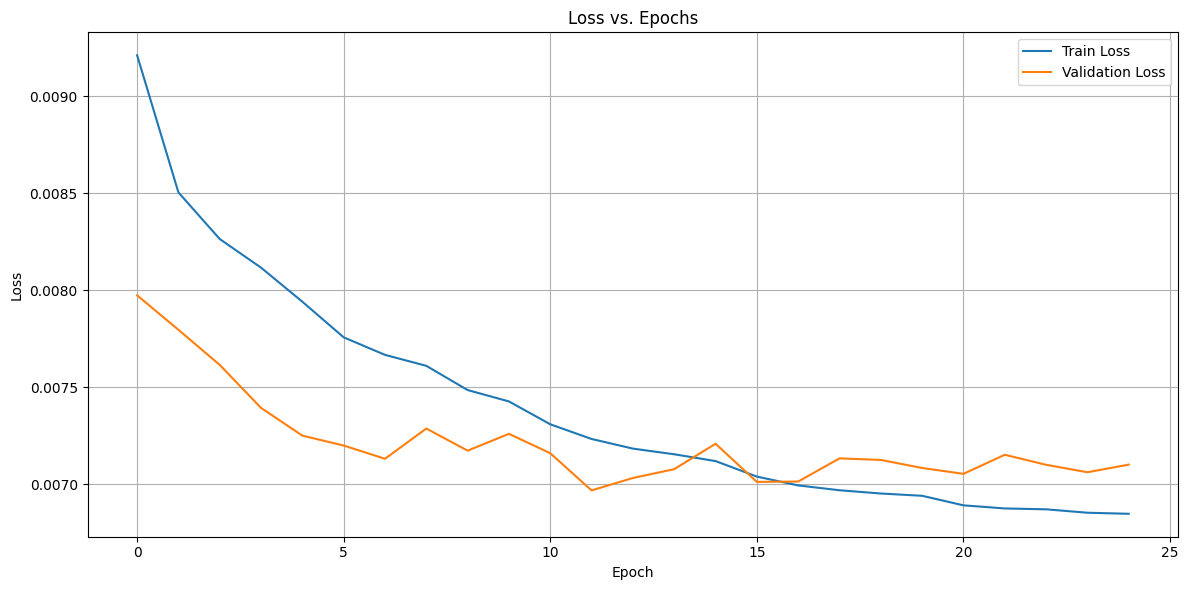

Training complete!


In [44]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

print("Training complete!")

In [45]:
torch.save(model2.state_dict(), "model2.pth")

print("Model saved successfully!")

Model saved successfully!



## 4. Reconstruct the Audio :

In [ ]:
batchs = []
for batch in val_loader:
    batchs.append(batch)
batch = batchs[1]
batch[1].shape

In [ ]:
from IPython.display import Audio, display

def reconstruct_audio(model, batch, a=0, b=0, n_fft=1024, hop_length=768):
    model.eval()
    X_mag, X_phase, Y_mag, Y_phase = batch
    
    with torch.no_grad():
        predicted_mask = model(X_mag)
        predicted_mask = predicted_mask.cpu().numpy()
        X_mag = X_mag.cpu().numpy()
        Y_mag = Y_mag.cpu().numpy()
        X_phase = X_phase.unsqueeze(1).cpu().numpy()
        Y_phase = Y_phase.unsqueeze(1).cpu().numpy()
    
    # Restaurer les dimensions originales (513 bins de fréquence)
    X_mag_full = np.zeros((X_mag.shape[0], 1, 513, X_mag.shape[3]))
    X_mag_full[:, :, :512, :] = X_mag
    X_phase_full = np.zeros((X_phase.shape[0], 1, 513, X_phase.shape[3]))
    X_phase_full[:, :, :512, :] = X_phase
    
    Y_mag_full = np.zeros((Y_mag.shape[0], 1, 513, Y_mag.shape[3]))
    Y_mag_full[:, :, :512, :] = Y_mag
    Y_phase_full = np.zeros((Y_phase.shape[0], 1, 513, Y_phase.shape[3]))
    Y_phase_full[:, :, :512, :] = Y_phase
    
    # Restaurer les dimensions du masque prédit
    predicted_mask_full = np.zeros((predicted_mask.shape[0], 1, 513, predicted_mask.shape[3]))
    predicted_mask_full[:, :, :512, :] = predicted_mask
    
    # Appliquer le masque prédit à l'amplitude d'entrée
    estimated_mag = predicted_mask_full * X_mag_full
    
    # Reconstituer le spectrogramme complexe estimé
    estimated_complex = estimated_mag * np.exp(1j * X_phase_full)
    
    # Reconstituer le spectrogramme complexe original
    original_complex = Y_mag_full * np.exp(1j * Y_phase_full)
    
    # Convertir les spectrogrammes complexes en signaux audio
    # Utiliser [a, b] pour accéder aux éléments spécifiés du batch et du canal
    estimated_audio = librosa.istft(estimated_complex[a, b], hop_length=hop_length)
    original_audio = librosa.istft(original_complex[a, b], hop_length=hop_length)
    
    return original_audio, estimated_audio, X_mag_full[a, b], estimated_mag[a, b], Y_mag_full[a, b]


def plot_audio(original_audio, estimated_audio):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(original_audio)
    plt.title("Original Audio")
    plt.xlabel("Time")

    plt.subplot(2, 1, 2)
    plt.plot(estimated_audio)
    plt.title("Estimated Audio")
    plt.xlabel("Time")

    plt.tight_layout()
    plt.show()


def plot_spectrograms(original_mag, estimated_mag):
    plt.figure(figsize=(12, 6))
    
    # Plot original magnitude spectrogram
    plt.subplot(2, 1, 1)
    plt.imshow(librosa.amplitude_to_db(original_mag, ref=np.max), aspect='auto', origin='lower')
    plt.title("Original Magnitude Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    
    # Plot estimated magnitude spectrogram
    plt.subplot(2, 1, 2)
    plt.imshow(librosa.amplitude_to_db(estimated_mag, ref=np.max), aspect='auto', origin='lower')
    plt.title("Estimated Magnitude Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

def display_audio(original_audio, estimated_audio, sr=8192):
    print("Original Audio:")
    display(Audio(original_audio, rate=sr))
    
    print("\nEstimated Audio:")
    display(Audio(estimated_audio, rate=sr))

C:\Users\PSDJ8092\AppData\Local\Temp\1\ipykernel_1696\1779783418.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_50_epochs.pth"))

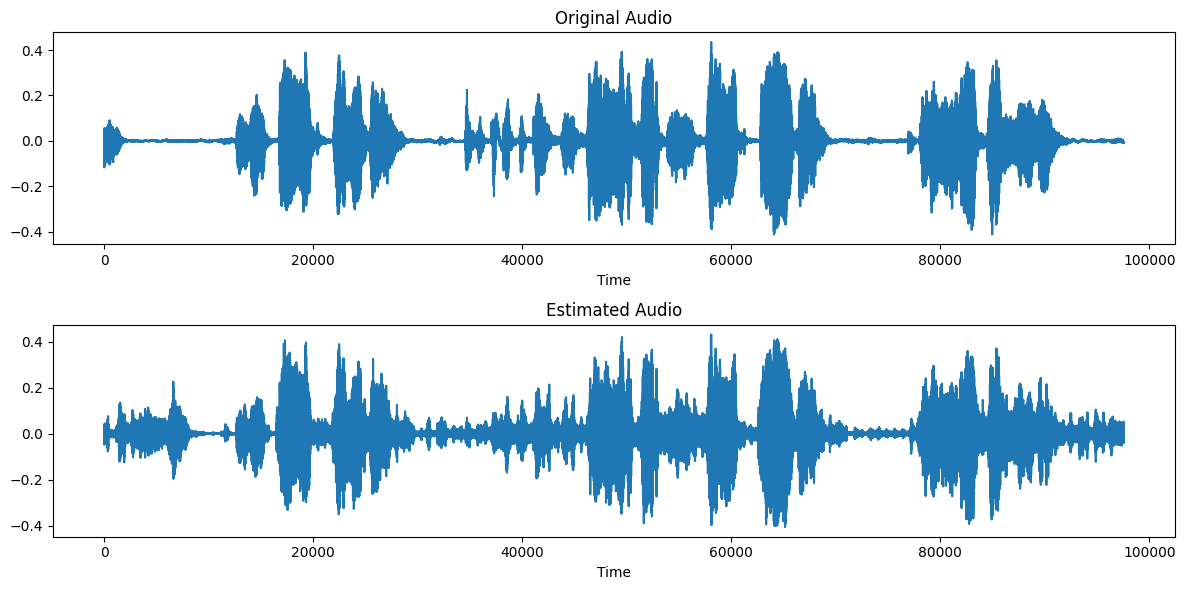

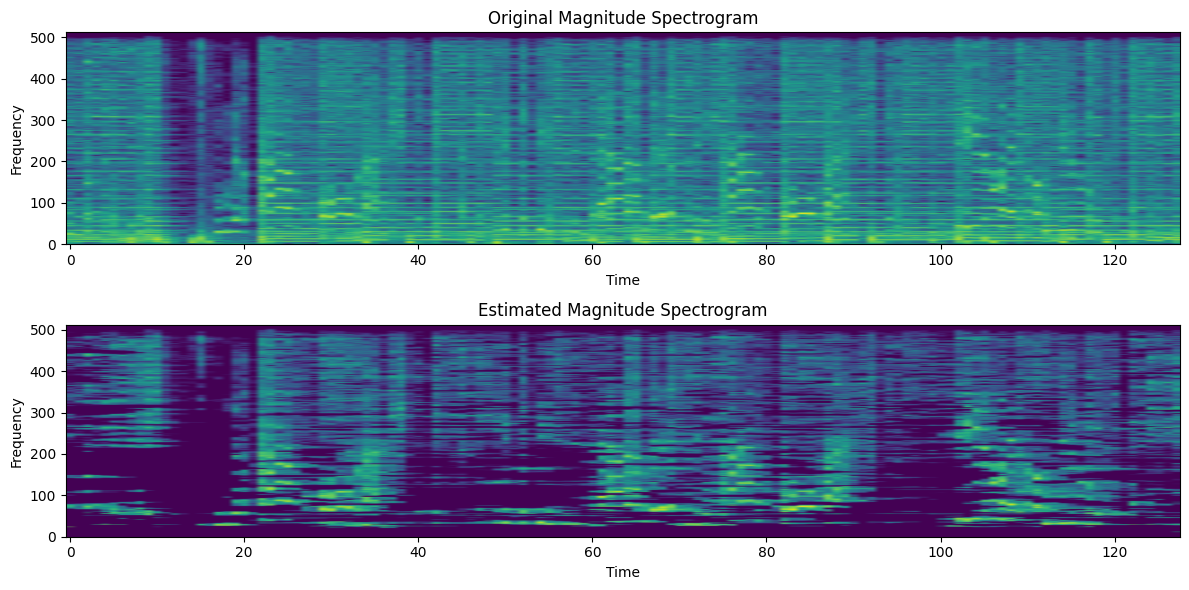

Original Audio:



Estimated Audio:


In [71]:
model = _UNet()
model.load_state_dict(torch.load("model_50_epochs.pth"))

original_audio, estimated_audio, original_mag, estimated_mag, _ = reconstruct_audio(model, batchs[0], a=40)

plot_audio(original_audio, estimated_audio)
plot_spectrograms(original_mag, estimated_mag)
display_audio(original_audio, estimated_audio)

These representations display the original and estimated audio signals over time, along with their respective spectrograms. A good correspondence is observed between the original and estimated signals, highlighting the effectiveness of the model's reconstruction.

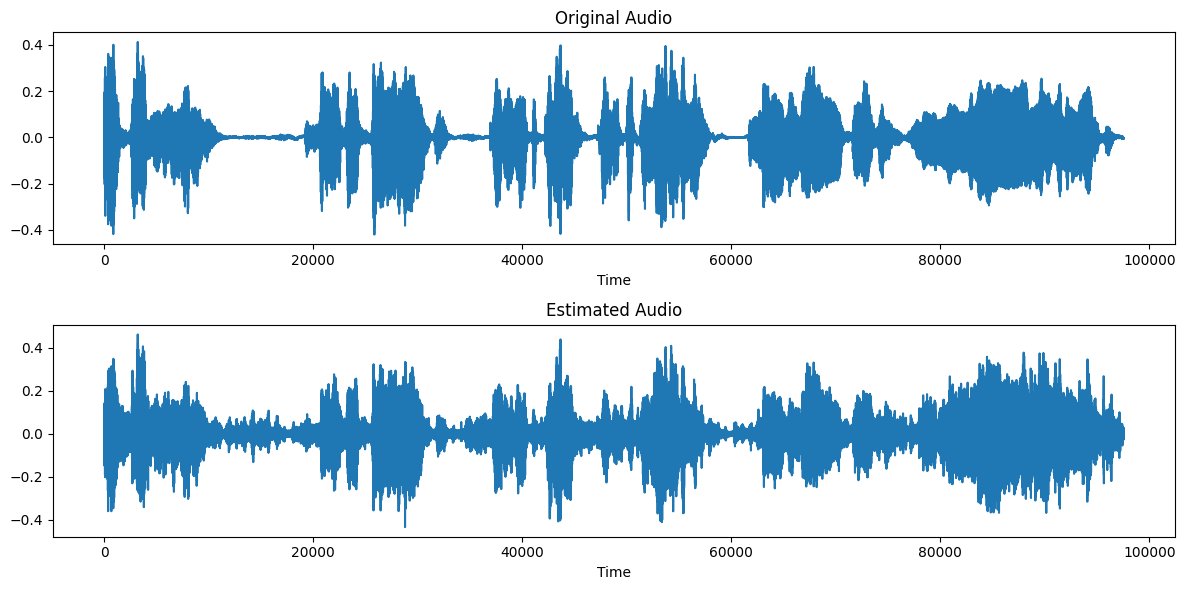

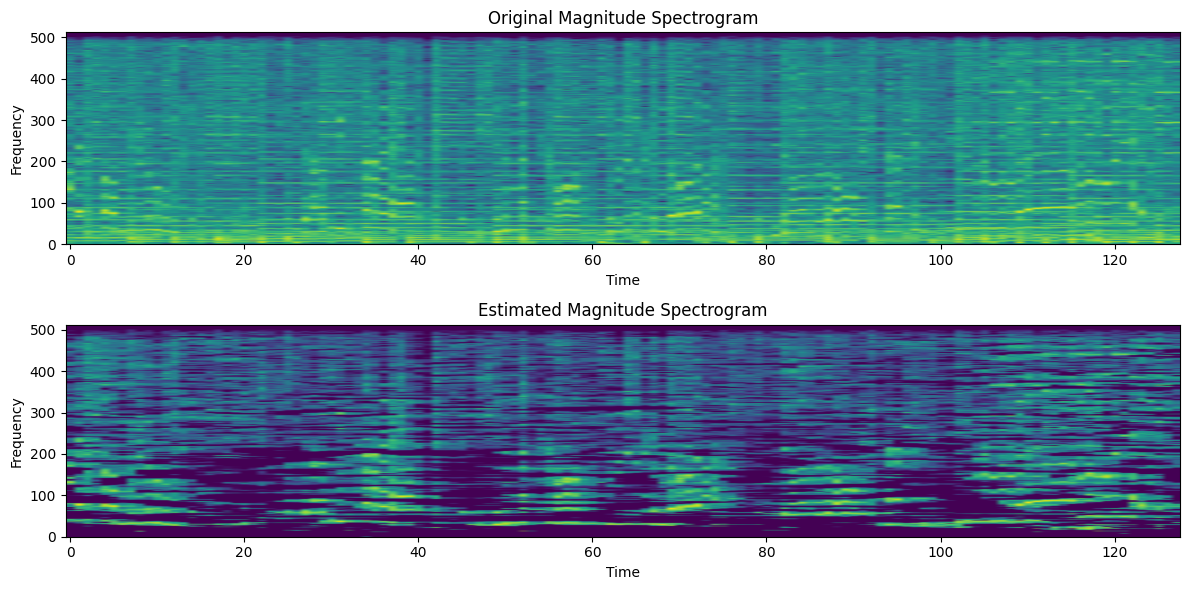

Original Audio:



Estimated Audio:


In [97]:
original_audio, estimated_audio, original_mag, estimated_mag, _ = reconstruct_audio(model, batchs[0], a=45)

plot_audio(original_audio, estimated_audio)
plot_spectrograms(original_mag, estimated_mag)
display_audio(original_audio, estimated_audio)

These representations display the original and estimated audio signals over time for a second signal , along with their respective spectrograms. A good correspondence is observed between the original and estimated signals, highlighting the effectiveness of the model's reconstruction.

## 5. Results :

In [81]:
import museval

In [84]:
pairs = []

# Itérer sur les 20 premiers exemples du batch
for i in range(30, 63):
    # Reconstituer le signal audio et obtenir les spectrogrammes
    original_audio, estimated_audio, original_mag, estimated_mag, _ = reconstruct_audio(model, test_batch, a=i, b=0)
    
    # Ajouter la paire (original_audio, estimated_audio) à la liste
    pairs.append((original_audio, estimated_audio))

In [87]:
def evaluate_list_of_pairs(pairs, sr=8192, win=1.0, hop=1.0):
    """
    pairs: liste de tuples (original_audio, estimated_audio)
           où chacun est un numpy array 1D (mono).
    sr   : fréquence d'échantillonnage (non indispensable à museval, mais utile pour référence)
    win, hop : param. temporels pour museval (en secondes).
    
    Retourne une liste de dict: 
    [{"SDR": ..., "SIR": ..., "SAR": ...}, ...]
    où chaque dict correspond à un extrait (original-estimated).
    """
    results = []
    for idx, (orig, estim) in enumerate(pairs):
        # 1) Aligner les longueurs
        min_len = min(len(orig), len(estim))
        orig = orig[:min_len]
        estim = estim[:min_len]
        # 2) Reshape en (nsrc, nsampl, nchan) = (1, n_samples, 1)
        ref_audio = orig.reshape(1, -1, 1)
        est_audio = estim.reshape(1, -1, 1)
        # 3) Calcul SDR, SIR, SAR (matrices [1, n_frames])
        sdr, sir, sar, _ = museval.evaluate(
            ref_audio,
            est_audio,
            win=win,
            hop=hop,
            mode="v4"
        )
        # sdr, sir, sar renvoient chacun un array (1, n_frames)
        # 4) Extraire la ligne unique (0) et prendre la médiane
        # => axis=1 puisque shape = (1, n_frames)
        sdr_median = np.median(sdr[0, :])
        sir_median = np.median(sir[0, :])
        sar_median = np.median(sar[0, :])
        # 5) Stocker le résultat pour cet extrait
        results.append({
            "SDR": sdr_median,
            "SIR": sir_median,
            "SAR": sar_median
        })
        print(f"Extrait #{idx+1} -> SDR: {sdr_median:.2f}, "
              f"SIR: {sir_median:.2f}, SAR: {sar_median:.2f}")
    
    # Calculer les moyennes des métriques
    avg_sdr = np.mean([r['SDR'] for r in results])
    avg_sir = np.mean([r['SIR'] for r in results])
    avg_sar = np.mean([r['SAR'] for r in results])
    
    print(f"\nScore moyen sur tous les extraits -> SDR: {avg_sdr:.2f}, "
          f"SIR: {avg_sir:.2f}, SAR: {avg_sar:.2f}")
    
    return results

In [88]:
results = evaluate_list_of_pairs(pairs, sr=8192, win=1.0, hop=1.0)

Extrait #1 -> SDR: -0.22, SIR: 1.57, SAR: inf
Extrait #2 -> SDR: 1.17, SIR: -0.18, SAR: inf
Extrait #3 -> SDR: 0.03, SIR: -5.94, SAR: inf
Extrait #4 -> SDR: -66.71, SIR: -64.43, SAR: inf
Extrait #5 -> SDR: -6.47, SIR: -39.01, SAR: inf
Extrait #6 -> SDR: -2.26, SIR: -26.88, SAR: inf
Extrait #7 -> SDR: 0.17, SIR: -31.45, SAR: inf
Extrait #8 -> SDR: -7.17, SIR: -18.35, SAR: inf
Extrait #9 -> SDR: -47.89, SIR: -0.18, SAR: inf
Extrait #10 -> SDR: -0.74, SIR: -3.33, SAR: inf
Extrait #11 -> SDR: -1.07, SIR: -22.72, SAR: inf
Extrait #12 -> SDR: -2.27, SIR: -30.49, SAR: inf
Extrait #13 -> SDR: -56.16, SIR: -11.03, SAR: inf
Extrait #14 -> SDR: 2.39, SIR: -9.70, SAR: inf
Extrait #15 -> SDR: 0.59, SIR: -28.37, SAR: inf
Extrait #16 -> SDR: 0.39, SIR: -8.61, SAR: inf
Extrait #17 -> SDR: -2.99, SIR: -7.29, SAR: inf
Extrait #18 -> SDR: nan, SIR: nan, SAR: nan
Extrait #19 -> SDR: -1.19, SIR: 1.49, SAR: inf
Extrait #20 -> SDR: -0.23, SIR: 1.89, SAR: inf
Extrait #21 -> SDR: -2.04, SIR: 0.32, SAR: inf
Ext

In [90]:
print("Tous les résultats:")
for i, r in enumerate(results):
    print(f"Fichier {i+1}: SDR={r['SDR']:.2f}, SIR={r['SIR']:.2f}, SAR={r['SAR']:.2f}")

Tous les résultats:
Fichier 1: SDR=-0.22, SIR=1.57, SAR=inf
Fichier 2: SDR=1.17, SIR=-0.18, SAR=inf
Fichier 3: SDR=0.03, SIR=-5.94, SAR=inf
Fichier 4: SDR=-66.71, SIR=-64.43, SAR=inf
Fichier 5: SDR=-6.47, SIR=-39.01, SAR=inf
Fichier 6: SDR=-2.26, SIR=-26.88, SAR=inf
Fichier 7: SDR=0.17, SIR=-31.45, SAR=inf
Fichier 8: SDR=-7.17, SIR=-18.35, SAR=inf
Fichier 9: SDR=-47.89, SIR=-0.18, SAR=inf
Fichier 10: SDR=-0.74, SIR=-3.33, SAR=inf
Fichier 11: SDR=-1.07, SIR=-22.72, SAR=inf
Fichier 12: SDR=-2.27, SIR=-30.49, SAR=inf
Fichier 13: SDR=-56.16, SIR=-11.03, SAR=inf
Fichier 14: SDR=2.39, SIR=-9.70, SAR=inf
Fichier 15: SDR=0.59, SIR=-28.37, SAR=inf
Fichier 16: SDR=0.39, SIR=-8.61, SAR=inf
Fichier 17: SDR=-2.99, SIR=-7.29, SAR=inf
Fichier 18: SDR=nan, SIR=nan, SAR=nan
Fichier 19: SDR=-1.19, SIR=1.49, SAR=inf
Fichier 20: SDR=-0.23, SIR=1.89, SAR=inf
Fichier 21: SDR=-2.04, SIR=0.32, SAR=inf
Fichier 22: SDR=-1.19, SIR=-0.73, SAR=inf
Fichier 23: SDR=-0.59, SIR=0.95, SAR=inf
Fichier 24: SDR=0.03, SIR=